In [1]:
#imports

import pandas as pd
import numpy as np

from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

# open the main master peak peakCleaned_60nt file (to later calculate the z-score for each peak of the file) 
master_peak=pd.read_csv("../snDynaTag_mm10_ESC_EpiLC_filtered_1000_score_peaks_per_TF_merged/master_peakCleaned_60nt.bed", sep="\t", header=None)
master_peak.columns = ["chr", "start", "end"]

for i in range(1,1+len(master_peak)):
    master_peak.loc[i-1, "peak_number"] = f"peak_{i}"#i

display(master_peak)
#master_peak.head()

# remove chrUn_GL456370 and chrM (similar to creating the bed file)
master_peak = master_peak[master_peak["chr"] != "chrUn_GL456370"]
master_peak = master_peak[master_peak["chr"] != "chrM"]

# reset index
master_peak = master_peak.reset_index(drop=True)

print(master_peak.shape)

print(master_peak.tail())


,chr,start,end,peak_number
0,chr1,3000354,3000621,peak_1
1,chr1,3344239,3344375,peak_2
2,chr1,3423800,3424266,peak_3
3,chr1,3483016,3483312,peak_4
4,chr1,3671770,3672445,peak_5
...,...,...,...,...
24892,chrY,90808315,90808766,peak_24893
24893,chrY,90810161,90810301,peak_24894
24894,chrY,90810593,90811114,peak_24895
24895,chrY,90811889,90812674,peak_24896


(24892, 4)
        chr     start       end peak_number
24887  chrY  90808315  90808766  peak_24893
24888  chrY  90810161  90810301  peak_24894
24889  chrY  90810593  90811114  peak_24895
24890  chrY  90811889  90812674  peak_24896
24891  chrY  90818664  90818899  peak_24897


In [ ]:
# open the totalBAMreadsPerCell.txt file
totalBAMreadsPerCell = pd.read_csv("./totalBAMreadsPerCell.txt", sep=" ", header=None, index_col=0)
totalBAMreadsPerCell.columns = ["totalBAMreads"]
#remove the index name
totalBAMreadsPerCell.index.name = None
print(totalBAMreadsPerCell.shape)

# remove the cells with less then 250 totalBAMreads
totalBAMreadsPerCell = totalBAMreadsPerCell[totalBAMreadsPerCell["totalBAMreads"] > 250]
print(totalBAMreadsPerCell.shape)

display(totalBAMreadsPerCell)



(2892, 1)
(2529, 1)


,totalBAMreads
R0C0_MYC_EpiLC_1_S1,1128
R0C10_MYC_ESC_1_S386,15046
R0C12_MYC_ESC_1_S387,4534
R0C14_MYC_ESC_2_S577,29110
R0C21_MYC_EpiLC_2_S206,8600
...,...
R9C67_NANOG_ESC_2_S1309,107546
R9C6_NANOG_EpiLC_1_S747,29262
R9C6_NANOG_EpiLC_2_S957,5804
R9C7_NANOG_EpiLC_1_S748,2210


In [ ]:
# open the binned count files for MYC_ESC and MYC_EpiLC
counts_MYC_ESC = pd.read_csv("./merged_count_MYC_ESC_binned.txt", sep="\t", index_col=0)
counts_MYC_EpiLC = pd.read_csv("./merged_count_MYC_EpiLC_binned.txt", sep="\t", index_col=0)

print(counts_MYC_ESC.shape)
print(counts_MYC_EpiLC.shape)



#remove the cells (columns) with less than 250 total reads
counts_MYC_ESC = counts_MYC_ESC.loc[:,counts_MYC_ESC.sum(axis=0) > 250]
counts_MYC_EpiLC = counts_MYC_EpiLC.loc[:,counts_MYC_EpiLC.sum(axis=0) > 250]

print(counts_MYC_ESC.shape)
print(counts_MYC_EpiLC.shape)



print(counts_MYC_ESC.columns.isin(totalBAMreadsPerCell.index).sum())
print(counts_MYC_EpiLC.columns.isin(totalBAMreadsPerCell.index).sum())



(2489200, 360)
(2489200, 385)
(2489200, 283)
(2489200, 341)
283
340


In [ ]:

# all the samples in the files
samples_MYC_ESC = counts_MYC_ESC.columns.tolist()
samples_MYC_EpiLC = counts_MYC_EpiLC.columns.tolist()
print(samples_MYC_ESC)

# add a column as integer is changed for each 100 rows (this is to recognise all the bins of a peak)
counts_MYC_ESC["peak"] = np.arange(len(counts_MYC_ESC)) // 100
counts_MYC_EpiLC["peak"] = np.arange(len(counts_MYC_EpiLC)) // 100

#display(counts_MYC_ESC.tail(5))


['R0C10_MYC_ESC_1_S386', 'R38C17_MYC_ESC_1_S503', 'R3C52_MYC_ESC_2_S611', 'R0C47_MYC_ESC_2_S581', 'R44C47_MYC_ESC_1_S571', 'R41C67_MYC_ESC_1_S547', 'R40C33_MYC_ESC_2_S701', 'R41C47_MYC_ESC_1_S544', 'R38C29_MYC_ESC_1_S505', 'R43C28_MYC_ESC_1_S559', 'R36C68_MYC_ESC_2_S671', 'R39C66_MYC_ESC_2_S693', 'R37C48_MYC_ESC_1_S489', 'R6C33_MYC_ESC_1_S456', 'R2C46_MYC_ESC_2_S600', 'R5C65_MYC_ESC_2_S635', 'R37C51_MYC_ESC_2_S677', 'R3C9_MYC_ESC_2_S603', 'R43C14_MYC_ESC_1_S556', 'R37C49_MYC_ESC_1_S490', 'R5C14_MYC_ESC_1_S445', 'R43C45_MYC_ESC_1_S562', 'R39C68_MYC_ESC_2_S694', 'R6C9_MYC_ESC_1_S451', 'R43C66_MYC_ESC_1_S565', 'R4C13_MYC_ESC_2_S615', 'R44C28_MYC_ESC_2_S739', 'R41C35_MYC_ESC_2_S719', 'R39C47_MYC_ESC_2_S689', 'R38C52_MYC_ESC_2_S683', 'R6C27_MYC_ESC_2_S640', 'R44C28_MYC_ESC_1_S568', 'R0C27_MYC_ESC_2_S578', 'R7C45_MYC_ESC_1_S463', 'R3C11_MYC_ESC_2_S604', 'R8C15_MYC_ESC_1_S468', 'R5C15_MYC_ESC_2_S627', 'R38C35_MYC_ESC_1_S508', 'R6C10_MYC_ESC_1_S452', 'R1C53_MYC_ESC_2_S593', 'R36C50_MYC_ESC_1_S

,R0C10_MYC_ESC_1_S386,R38C17_MYC_ESC_1_S503,R3C52_MYC_ESC_2_S611,R0C47_MYC_ESC_2_S581,R44C47_MYC_ESC_1_S571,R41C67_MYC_ESC_1_S547,R40C33_MYC_ESC_2_S701,R41C47_MYC_ESC_1_S544,R38C29_MYC_ESC_1_S505,R43C28_MYC_ESC_1_S559,...,R40C67_MYC_ESC_1_S537,R3C53_MYC_ESC_2_S612,R40C17_MYC_ESC_1_S526,R1C11_MYC_ESC_2_S585,R39C35_MYC_ESC_2_S688,R5C46_MYC_ESC_1_S447,R5C29_MYC_ESC_2_S630,R6C11_MYC_ESC_1_S453,R5C35_MYC_ESC_1_S446,peak
chrY:90821007-90821057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24891
chrY:90821057-90821107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24891
chrY:90821107-90821157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24891
chrY:90821157-90821207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24891
chrY:90821207-90821257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24891


In [ ]:
##### additional cell for Normalization

# sum of counts_MYC_ESC over each cell !
counts_MYC_ESC_sum = counts_MYC_ESC[samples_MYC_ESC].sum(axis=0)
print(counts_MYC_ESC_sum.shape)
print(counts_MYC_ESC_sum.mean())
print(counts_MYC_ESC_sum.median())

# scale the count values of each cell to have the same sum of counts equal to 10000
counts_MYC_ESC_scaled = counts_MYC_ESC.copy()
for sample in samples_MYC_ESC:
    counts_MYC_ESC_scaled[sample] = counts_MYC_ESC[sample] * (10000 / counts_MYC_ESC_sum[sample])

#display(counts_MYC_ESC_scaled.head(5))

counts_MYC_ESC_scaled_sum = counts_MYC_ESC_scaled[samples_MYC_ESC].sum(axis=0)
print(counts_MYC_ESC_scaled_sum.shape)
print(counts_MYC_ESC_scaled_sum.mean())
print(counts_MYC_ESC_scaled_sum.median())

# sum of counts_MYC_EpiLC over each cell !
counts_MYC_EpiLC_sum = counts_MYC_EpiLC[samples_MYC_EpiLC].sum(axis=0)
print(counts_MYC_EpiLC_sum.shape)
print(counts_MYC_EpiLC_sum.mean())
print(counts_MYC_EpiLC_sum.median())

# scale the count values of each cell to have the same sum of counts equal to 10000
counts_MYC_EpiLC_scaled = counts_MYC_EpiLC.copy()
for sample in samples_MYC_EpiLC:
    counts_MYC_EpiLC_scaled[sample] = counts_MYC_EpiLC[sample] * (10000 / counts_MYC_EpiLC_sum[sample])

#display(counts_MYC_EpiLC_scaled.head(5))

counts_MYC_EpiLC_scaled_sum = counts_MYC_EpiLC_scaled[samples_MYC_EpiLC].sum(axis=0)
print(counts_MYC_EpiLC_scaled_sum.shape)
print(counts_MYC_EpiLC_scaled_sum.mean())
print(counts_MYC_EpiLC_scaled_sum.median())


#put the counts equal to the count scaled
counts_MYC_ESC = counts_MYC_ESC_scaled.copy()
counts_MYC_EpiLC = counts_MYC_EpiLC_scaled.copy()




(283,)
21998.26148409894
19820.0
(283,)
10000.0
10000.0
(341,)
25852.58651026393
16793.0
(341,)
10000.0
10000.0


In [ ]:
##### Z-score calculation #####
# calculate sum of the counts all samples for each index and call it culumn "mu_j"
counts_MYC_ESC["mu_j"] = counts_MYC_ESC[samples_MYC_ESC].mean(axis=1) # this is mean over cells
counts_MYC_EpiLC["mu_j"] = counts_MYC_EpiLC[samples_MYC_EpiLC].mean(axis=1)

# for each line of master_peak there are 100 lines in counts_MYC_ESC that has the same peak number
# sum of all sample for each peak in a new dataframe and call it Z^bar in master_peak
master_peak["2^(Z^bar_MYC_ESC)"] = counts_MYC_ESC.groupby("peak")[samples_MYC_ESC].mean().sum(axis=1) # mean over bins and sum over cells
master_peak["2^(Z^bar_MYC_EpiLC)"] = counts_MYC_EpiLC.groupby("peak")[samples_MYC_EpiLC].mean().sum(axis=1)

#display(master_peak.head(10))

# epsilon is added to avoid log(0) error
epsilon = 1e-10
master_peak["Z^bar_MYC_ESC"] = np.log2(master_peak["2^(Z^bar_MYC_ESC)"] + epsilon)
master_peak["Z^bar_MYC_EpiLC"] = np.log2(master_peak["2^(Z^bar_MYC_EpiLC)"] + epsilon)

display(master_peak.shape)

display(master_peak.tail(5))
print(len(master_peak))

(24892, 8)

,chr,start,end,peak_number,2^(Z^bar_MYC_ESC),2^(Z^bar_MYC_EpiLC),Z^bar_MYC_ESC,Z^bar_MYC_EpiLC
24887,chrY,90808315,90808766,peak_24893,17.871940,16.215837,4.159624,4.019332
24888,chrY,90810161,90810301,peak_24894,18.878320,10.449703,4.238659,3.385390
24889,chrY,90810593,90811114,peak_24895,15.736401,10.560255,3.976034,3.400573
24890,chrY,90811889,90812674,peak_24896,11.707270,6.021833,3.549333,2.590203
24891,chrY,90818664,90818899,peak_24897,0.831430,2.444057,-0.266334,1.289278


24892


In [ ]:

master_peak["sigma^2__MYC_ESC"] = 0.0
master_peak["sigma^2__MYC_EpiLC"] = 0.0

for peakind in range(len(master_peak)):
    if peakind % 100 == 0:
        print(peakind)
    peak_bins_MYC_ESC = counts_MYC_ESC[counts_MYC_ESC["peak"]==peakind]
    peak_bins_MYC_EpiLC = counts_MYC_EpiLC[counts_MYC_EpiLC["peak"]==peakind]
    #print(peak_bins_MYC_ESC.shape)
    #sigmapeak_bins_MYC_ESC = (peak_bins_MYC_ESC[samples_MYC_ESC]-peak_bins_MYC_ESC["mu_j"]).cov()
    #sigmapeak_bins_MYC_EpiLC = (peak_bins_MYC_EpiLC[samples_MYC_EpiLC]-peak_bins_MYC_EpiLC["mu_j"]).cov()
    #display(sigmapeak_bins_MYC_ESC)

    # sum of all peak_bins values
    sum_bins_cells_MYC_ESC = peak_bins_MYC_ESC[samples_MYC_ESC].sum().sum()
    sum_bins_cells_MYC_EpiLC = peak_bins_MYC_EpiLC[samples_MYC_EpiLC].sum().sum()
    

    #sunstract the peak_bins["mu_j"] values from the all other column in samples list (peak_bins[samples])
    peak_bins_minusave_MYC_ESC = peak_bins_MYC_ESC[samples_MYC_ESC].sub(peak_bins_MYC_ESC["mu_j"], axis=0)
    peak_bins_minusave_MYC_EpiLC = peak_bins_MYC_EpiLC[samples_MYC_EpiLC].sub(peak_bins_MYC_EpiLC["mu_j"], axis=0)
    
    #calculate the multiplication of the matrix with its transpose as a dataframe
    cov_MYC_ESC = peak_bins_minusave_MYC_ESC.dot(peak_bins_minusave_MYC_ESC.T)
    cov_MYC_EpiLC = peak_bins_minusave_MYC_EpiLC.dot(peak_bins_minusave_MYC_EpiLC.T)
    #display(cov_MYC_ESC)
    
    if sum_bins_cells_MYC_ESC != 0:
        master_peak.loc[peakind, "sigma^2__MYC_ESC"] = cov_MYC_ESC.sum().sum()/ (sum_bins_cells_MYC_ESC * np.log(2)*100) # sum over bins and cells

    if sum_bins_cells_MYC_EpiLC != 0:
        master_peak.loc[peakind, "sigma^2__MYC_EpiLC"] = cov_MYC_EpiLC.sum().sum()/ (sum_bins_cells_MYC_EpiLC * np.log(2)*100)
    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [ ]:
display(master_peak.head(5))
display(master_peak.tail(5))



,chr,start,end,peak_number,2^(Z^bar_MYC_ESC),2^(Z^bar_MYC_EpiLC),Z^bar_MYC_ESC,Z^bar_MYC_EpiLC,sigma^2__MYC_ESC,sigma^2__MYC_EpiLC
0,chr1,3000354,3000621,peak_1,0.000000,0.802978,-33.219281,-0.316568,0.000000,1.155055
1,chr1,3344239,3344375,peak_2,0.015327,0.000000,-6.027740,-33.219281,0.022035,0.000000
2,chr1,3423800,3424266,peak_3,0.000000,0.000000,-33.219281,-33.219281,0.000000,0.000000
3,chr1,3483016,3483312,peak_4,0.000000,1.846200,-33.219281,0.884559,0.000000,0.919212
4,chr1,3671770,3672445,peak_5,0.000000,0.827809,-33.219281,-0.272631,0.000000,0.757149


,chr,start,end,peak_number,2^(Z^bar_MYC_ESC),2^(Z^bar_MYC_EpiLC),Z^bar_MYC_ESC,Z^bar_MYC_EpiLC,sigma^2__MYC_ESC,sigma^2__MYC_EpiLC
24887,chrY,90808315,90808766,peak_24893,17.871940,16.215837,4.159624,4.019332,1.446196,1.291126
24888,chrY,90810161,90810301,peak_24894,18.878320,10.449703,4.238659,3.385390,1.759871,1.459070
24889,chrY,90810593,90811114,peak_24895,15.736401,10.560255,3.976034,3.400573,2.042800,1.418630
24890,chrY,90811889,90812674,peak_24896,11.707270,6.021833,3.549333,2.590203,2.183007,0.835653
24891,chrY,90818664,90818899,peak_24897,0.831430,2.444057,-0.266334,1.289278,0.599686,0.495649


In [10]:
master_peak['z-score'] = 0.0

# calculate z-score if the sum of variances is not zero
mask = (master_peak['sigma^2__MYC_ESC'] + master_peak['sigma^2__MYC_EpiLC']) != 0
master_peak.loc[mask, 'z-score'] = (master_peak.loc[mask, 'Z^bar_MYC_ESC'] - master_peak.loc[mask, 'Z^bar_MYC_EpiLC']) / np.sqrt(master_peak.loc[mask, 'sigma^2__MYC_ESC'] + master_peak.loc[mask, 'sigma^2__MYC_EpiLC'])

# calculate the 2 sided p-value for each z-score
master_peak['p-value'] = norm.sf(abs(master_peak['z-score'])) * 2

# calculate the adjusted p-value for each p-value dropping the NAN values
adjusted_p_values = multipletests(master_peak['p-value'].dropna(), method='fdr_bh')[1]

# reindex the adjusted p-values to match the index of master_peak
master_peak['adjusted p-value'] = pd.Series(adjusted_p_values, index=master_peak['p-value'].dropna().index).reindex(master_peak.index)


In [ ]:

print(len(master_peak))

display(master_peak)

24892


,chr,start,end,peak_number,2^(Z^bar_MYC_ESC),2^(Z^bar_MYC_EpiLC),Z^bar_MYC_ESC,Z^bar_MYC_EpiLC,sigma^2__MYC_ESC,sigma^2__MYC_EpiLC,z-score,p-value,adjusted p-value
0,chr1,3000354,3000621,peak_1,0.000000,0.802978,-33.219281,-0.316568,0.000000,1.155055,-30.614724,7.795462e-206,3.466940e-205
1,chr1,3344239,3344375,peak_2,0.015327,0.000000,-6.027740,-33.219281,0.022035,0.000000,183.181035,0.000000e+00,0.000000e+00
2,chr1,3423800,3424266,peak_3,0.000000,0.000000,-33.219281,-33.219281,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
3,chr1,3483016,3483312,peak_4,0.000000,1.846200,-33.219281,0.884559,0.000000,0.919212,-35.570955,3.941488e-277,2.351666e-276
4,chr1,3671770,3672445,peak_5,0.000000,0.827809,-33.219281,-0.272631,0.000000,0.757149,-37.863477,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24887,chrY,90808315,90808766,peak_24893,17.871940,16.215837,4.159624,4.019332,1.446196,1.291126,0.084795,9.324240e-01,1.000000e+00
24888,chrY,90810161,90810301,peak_24894,18.878320,10.449703,4.238659,3.385390,1.759871,1.459070,0.475586,6.343693e-01,9.860370e-01
24889,chrY,90810593,90811114,peak_24895,15.736401,10.560255,3.976034,3.400573,2.042800,1.418630,0.309306,7.570889e-01,1.000000e+00
24890,chrY,90811889,90812674,peak_24896,11.707270,6.021833,3.549333,2.590203,2.183007,0.835653,0.552040,5.809211e-01,9.278337e-01


In [12]:
display(master_peak.tail(25))

,chr,start,end,peak_number,2^(Z^bar_MYC_ESC),2^(Z^bar_MYC_EpiLC),Z^bar_MYC_ESC,Z^bar_MYC_EpiLC,sigma^2__MYC_ESC,sigma^2__MYC_EpiLC,z-score,p-value,adjusted p-value
24867,chrY,90734055,90734871,peak_24873,6.656874,7.775893,2.734845,2.959008,2.149871,2.314760,-0.106089,0.915511,1.000000
24868,chrY,90735008,90735357,peak_24874,6.831512,6.403965,2.772205,2.678965,2.120444,1.797321,0.047107,0.962428,1.000000
24869,chrY,90739908,90740508,peak_24875,3.211137,6.243151,1.683084,2.642274,2.161732,1.499948,-0.501262,0.616187,0.966364
24870,chrY,90742408,90742732,peak_24876,4.203326,6.557099,2.071531,2.713058,1.204615,1.355472,-0.400947,0.688459,1.000000
24871,chrY,90765246,90766042,peak_24877,9.719526,9.579180,3.280886,3.259902,1.486512,0.608950,0.014496,0.988434,1.000000
24872,chrY,90768359,90768631,peak_24878,7.730115,6.983270,2.950490,2.803903,1.637971,0.420901,0.102160,0.918630,1.000000
24873,chrY,90772113,90772929,peak_24879,24.298746,27.230960,4.602810,4.767176,0.963460,0.980825,-0.117878,0.906164,1.000000
24874,chrY,90777023,90777327,peak_24880,7.080669,12.427662,2.823886,3.635483,0.469515,1.237382,-0.621208,0.534463,0.876464
24875,chrY,90783650,90784186,peak_24881,19.897998,26.545646,4.314551,4.730403,0.841701,0.717697,-0.333012,0.739125,1.000000
24876,chrY,90784746,90785099,peak_24882,20.441705,26.538993,4.353444,4.730042,0.851581,0.728232,-0.299623,0.764465,1.000000


In [13]:
# save master_peak in a file
master_peak.to_csv("master_peak_ZSCOREresults_MYC_ESC_EpiLC_60nt_REVIEW_NORMALIZED.txt", sep="\t", index=False, header=True)


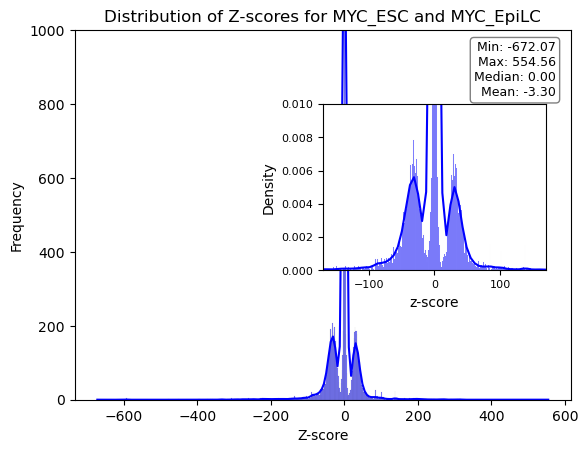

In [ ]:
# Main plot

sns.histplot(master_peak['z-score'], bins=1000, kde=True, color='blue') #, stat='density'

z_min = master_peak['z-score'].min()
z_max = master_peak['z-score'].max()
z_median = master_peak['z-score'].median()
z_mean = master_peak['z-score'].mean()
    
# Add text to the plot
plt.text(0.97, 0.97, f"Min: {z_min:.2f}\nMax: {z_max:.2f}\nMedian: {z_median:.2f}\nMean: {z_mean:.2f}", 
        transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    
plt.title(f'Distribution of Z-scores for MYC_ESC and MYC_EpiLC', fontsize=12)
plt.xlabel('Z-score')
plt.ylabel('Frequency')

plt.ylim(0, 1000)
    
# Inlet plot
inset_ax = plt.gca().inset_axes([0.5, 0.35, 0.45, 0.45])  # [x, y, width, height]
sns.histplot(master_peak['z-score'], bins=np.linspace(-170, 170, 551), kde=True, color='blue', stat='density', ax=inset_ax)
inset_ax.set_xlim(-170, 170)

inset_ax.set_ylim(0, 0.01)

inset_ax.tick_params(axis='both', which='major', labelsize=8)
    
plt.show()

